### Image Classification

#### Dataset
This project will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total).

In [ ]:
import cv2
import math

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from pickle import dump, load
from torch.utils.data import random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from torch.utils.data import Dataset
import os
from natsort import natsorted

import torchvision
import torchvision.transforms as transforms
import ssl

In [ ]:
# always check your version
print(torch.__version__)

2.2.0+cpu


## 1 Function implementations


### 1.1 Dataset class

In [ ]:
# ImageFolder class to load images in different folders
class TinyImage30(ImageFolder):
    def __init__(self,
                  root="./comp5625m-artificial-intelligence-2024/train_set/",
                  transform=transforms.ToTensor()):
        super(TinyImage30, self).__init__(root=root, transform=transform)

    def __len__(self):
        return len(self.imgs)

In [ ]:
train = TinyImage30()

In [ ]:
print(len(train)*0.8)
print(len(train)*0.2)

10800.0
2700.0


In [ ]:
# Split the dataset into train(0.8) and validation(0.2) sets with seed at 0
torch.manual_seed(0)
train_set, val_set = random_split(train, [10800, 2700])

In [ ]:
# DataLoader
train_set = DataLoader(train_set, batch_size=32, shuffle=True)
val_set = DataLoader(val_set, batch_size=32)

### 1.2 Define a MLP model class

- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [ ]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*64*64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
mlp_model = MLP()

mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=0.001, momentum=0.9)
mlp_loss_fn = nn.CrossEntropyLoss()

print(mlp_model)

MLP(
  (fc1): Linear(in_features=12288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


### 1.3 Define a CNN model class

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers
- Loss function
- Optimiser


In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 40, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 80, 3)

        self.fc1 = nn.Linear(80*14*14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
cnn_model = CNN()

cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
cnn_loss_fn = nn.CrossEntropyLoss()

print(cnn_model)

CNN(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


## 2 Model training


### 2.1 Train both MLP and CNN model

In [ ]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def train_model(n_epochs, model, optimizer, loss_fn, file_name):
    new_val_acc = 0.0
    statsrec = np.zeros((4, n_epochs))

    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}: ")

        # train
        train_loss = 0.0
        train_acc = 0.0
        n = 0
        for data, labels in train_set:
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += torch.tensor(topk_accuracy(outputs, labels)).item()
            n += 1

        train_loss = train_loss/n
        train_acc = train_acc/n
        print(f"training loss: {train_loss: .3f}")
        print(f"training topk accuracy: {train_acc: .3f}")

        # validation
        val_loss = 0.0
        val_acc = 0.0
        n = 0
        for data, labels in val_set:
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_acc += torch.tensor(topk_accuracy(outputs, labels)).item()
            n += 1

        val_loss = val_loss/n
        val_acc = val_acc/n

        statsrec[:, epoch] = (train_loss, train_acc, val_loss, val_acc)

        # save the model with the best accuracy
        if val_acc > new_val_acc:
            new_val_acc = val_acc
            torch.save({"state_dict": model.state_dict()},
                      "./comp5625m-artificial-intelligence-2024/"+file_name+"_best_acc.pt")
            print(f"maximum validation accuracy: {new_val_acc: .3f}")

    main_dir = "./comp5625m-artificial-intelligence-2024/"
    torch.save({"state_dict": model.state_dict(), "stats": statsrec}, main_dir+file_name+".pt")

In [ ]:
def plot_graph(file_name, title):
    main_dir = "./comp5625m-artificial-intelligence-2024/"
    data = torch.load(main_dir+file_name+".pt")
    statsrec = data["stats"]

    # loss
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'b', label="training loss")
    plt.plot(statsrec[2], 'g', label="validation loss")
    plt.legend(loc="lower right")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(title)

    # accuracy
    ax2 = ax1.twinx()
    ax2.plot(statsrec[1], 'r', label="training accuracy")
    ax2.plot(statsrec[3], 'c', label="validation accuracy")
    plt.legend(loc="upper right")
    ax2.set_ylabel('accuracy')
    plt.show()

In [ ]:
train_model(25, mlp_model, mlp_optimizer, mlp_loss_fn, "mlp")

Epoch 1: 
training loss:  3.367
training topk accuracy:  6.315
maximum validation accuracy:  9.105
Epoch 2: 
training loss:  3.217
training topk accuracy:  10.993
maximum validation accuracy:  11.348
Epoch 3: 
training loss:  3.090
training topk accuracy:  12.981
maximum validation accuracy:  13.468
Epoch 4: 
training loss:  2.994
training topk accuracy:  15.431
maximum validation accuracy:  14.461
Epoch 5: 
training loss:  2.917
training topk accuracy:  17.354
maximum validation accuracy:  16.336
Epoch 6: 
training loss:  2.859
training topk accuracy:  18.861
maximum validation accuracy:  16.863
Epoch 7: 
training loss:  2.812
training topk accuracy:  20.091
maximum validation accuracy:  18.493
Epoch 8: 
training loss:  2.778
training topk accuracy:  21.015
Epoch 9: 
training loss:  2.740
training topk accuracy:  21.477
maximum validation accuracy:  18.566
Epoch 10: 
training loss:  2.709
training topk accuracy:  22.753
Epoch 11: 
training loss:  2.674
training topk accuracy:  23.438


In [ ]:
train_model(30, cnn_model, cnn_optimizer, cnn_loss_fn, "cnn")

Epoch 1: 
training loss:  3.400
training topk accuracy:  4.114
maximum validation accuracy:  4.559
Epoch 2: 
training loss:  3.388
training topk accuracy:  5.168
maximum validation accuracy:  8.039
Epoch 3: 
training loss:  3.340
training topk accuracy:  9.246
Epoch 4: 
training loss:  3.199
training topk accuracy:  10.827
maximum validation accuracy:  10.600
Epoch 5: 
training loss:  3.108
training topk accuracy:  12.371
maximum validation accuracy:  13.321
Epoch 6: 
training loss:  3.037
training topk accuracy:  14.238
maximum validation accuracy:  14.020
Epoch 7: 
training loss:  2.973
training topk accuracy:  15.884
maximum validation accuracy:  15.650
Epoch 8: 
training loss:  2.916
training topk accuracy:  17.446
maximum validation accuracy:  16.752
Epoch 9: 
training loss:  2.850
training topk accuracy:  19.064
maximum validation accuracy:  18.640
Epoch 10: 
training loss:  2.751
training topk accuracy:  21.200
maximum validation accuracy:  20.478
Epoch 11: 
training loss:  2.63

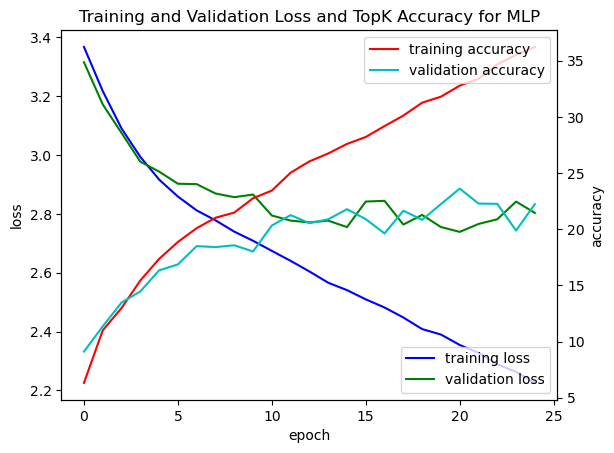

In [ ]:
plot_graph("mlp", "Training and Validation Loss and TopK Accuracy for MLP")

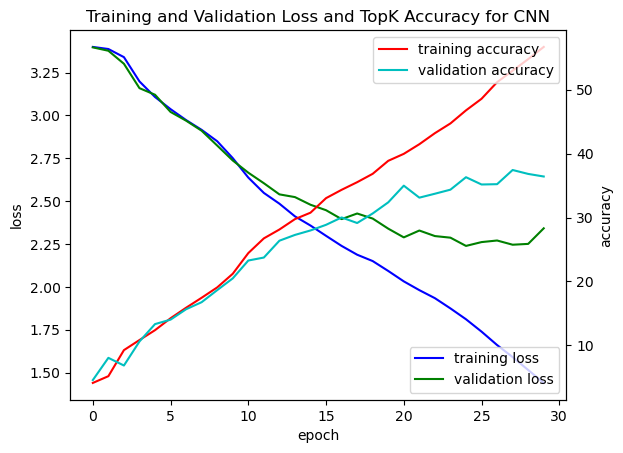

In [ ]:
plot_graph("cnn", "Training and Validation Loss and TopK Accuracy for CNN")

In [ ]:
summary(mlp_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 120]       1,474,680
            Linear-2                   [-1, 84]          10,164
            Linear-3                   [-1, 30]           2,550
Total params: 1,487,394
Trainable params: 1,487,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 5.67
Estimated Total Size (MB): 5.72
----------------------------------------------------------------


In [ ]:
summary(cnn_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 62, 62]           1,120
         MaxPool2d-2           [-1, 40, 31, 31]               0
            Conv2d-3           [-1, 80, 29, 29]          28,880
         MaxPool2d-4           [-1, 80, 14, 14]               0
            Linear-5                  [-1, 120]       1,881,720
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 30]           2,550
Total params: 1,924,434
Trainable params: 1,924,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.10
Params size (MB): 7.34
Estimated Total Size (MB): 9.49
----------------------------------------------------------------


__Total number of parameters for MLP__ : 1,487,394

__Total number of paramters for CNN__ : 1,924,434

Here, the shape of input is (3, 64, 64) where 3 indicates the number of colour channels and 64 indicates the 64x64 images. The model predicts the class of each image, and the shape of output is (1, 30) as there are 30 classes in total.

The first model, MLP, consists of 2 linear hidden layers, one with 120 neurons and another one with 80 neurons, the relu is used as an activation function. The optimizer is defined by SGD with the learning rate at 0.001, and the loss function is defined by CrossEntropyLoss. There are 1,487,394 trainable parameters in this model.

The other model, CNN, consists of 2 convolution layers with 40 kernels in the first one and 80 kernels in the second one with the size of 3x3 for both layers. The outputs from both convolution layers are max pooled by 2x2 filter. Then, it also contains 2 fully connected layers with 120 and 84 neurons respectively, with the relu activation function. Again the optimizer is defined by SGD with the learning rate at 0.001, and the loss function is defined by CrossEntropyLoss. There are 1,924,434 trainable parameters in this model.

As shown by the graphs, the training accuracy increases, while the validation accuracy iterates at a certain point, and the training loss decreases, while the validation loss increases for both models. For MLP, the validation accuracy remains at about 20 from 15 epoch, and it remains at about 37 from 27 epoch for CNN.

This indicates that the CNN model works better as the model describes the data well with more trainable parameters.

### 2.2 Generating confusion matrix and ROC curves

In [ ]:
def cf_matrix(dataset, name):
    results = torch.load("./comp5625m-artificial-intelligence-2024/cnn_best_acc.pt")
    cnn_model.load_state_dict(results['state_dict'])

    y_pred = []
    y_true = []
    for data, labels in dataset:
        output = cnn_model(data)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

    cf_m = confusion_matrix(y_true, y_pred)
    cf_m = cf_m/np.sum(cf_m, axis=1)[:, None]
    cf_df = pd.DataFrame(cf_m)
    print("Confusion matrix for the "+name+" set")
    print(np.round_(cf_m, decimals=2))
    plt.figure(figsize=(12, 7))
    sns.heatmap(cf_df, cmap="coolwarm")
    plt.savefig(name+"_cf_matrix.png")
    return cf_m

In [ ]:
# ROC curve for the two top and two bottom classes
def ROC_curve(cf_m):
    diags = np.diag(cf_m)
    top2 = diags.argsort()[::-1][:2]
    bottom2 = diags.argsort()[:2]

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')

    y = np.arange(0, 30)
    j=1
    for i in top2:
        fpr, tpr, threshold = roc_curve(y, diags, pos_label=i)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Top {j} class (AUC={roc_auc: .3f})")
        j += 1
    j=1
    for i in bottom2:
        fpr, tpr, threshold = roc_curve(y, diags, pos_label=i)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Bottom {j} class (AUC={roc_auc: .3f})")
        j += 1

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2)
    plt.show()

Confusion matrix for the training set
[[0.48 0.   0.   0.05 0.   0.01 0.01 0.01 0.12 0.   0.   0.   0.01 0.01
  0.   0.   0.   0.   0.1  0.   0.09 0.   0.01 0.04 0.01 0.   0.01 0.01
  0.01 0.  ]
 [0.01 0.45 0.01 0.01 0.   0.04 0.01 0.01 0.   0.05 0.02 0.02 0.   0.03
  0.   0.08 0.02 0.01 0.01 0.01 0.02 0.   0.01 0.   0.06 0.09 0.   0.01
  0.01 0.01]
 [0.01 0.01 0.58 0.01 0.02 0.01 0.   0.01 0.   0.   0.13 0.   0.02 0.07
  0.   0.01 0.   0.   0.01 0.03 0.01 0.   0.   0.   0.01 0.01 0.01 0.
  0.01 0.03]
 [0.04 0.   0.   0.68 0.   0.   0.01 0.01 0.12 0.   0.   0.   0.01 0.
  0.   0.   0.   0.   0.03 0.   0.03 0.   0.01 0.03 0.   0.   0.   0.
  0.01 0.  ]
 [0.   0.   0.02 0.   0.91 0.   0.   0.   0.   0.   0.01 0.01 0.   0.03
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.01]
 [0.01 0.01 0.   0.02 0.   0.48 0.02 0.04 0.   0.05 0.   0.01 0.02 0.
  0.01 0.05 0.03 0.04 0.01 0.01 0.01 0.   0.01 0.03 0.03 0.03 0.01 0.02
  0.05 0.01]
 [0.04 0.   0.   0.01 0.   0.0

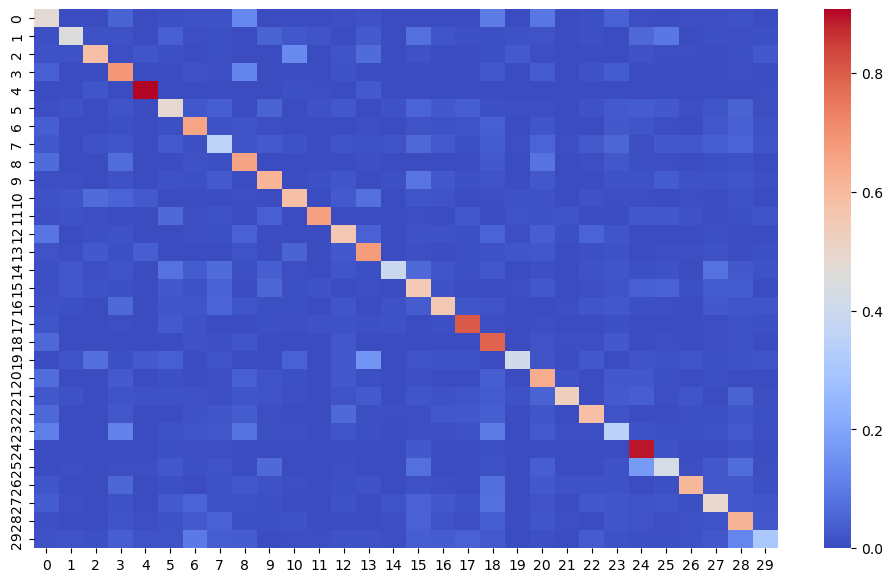

In [ ]:
# training set
train_cf= cf_matrix(train_set, "training")

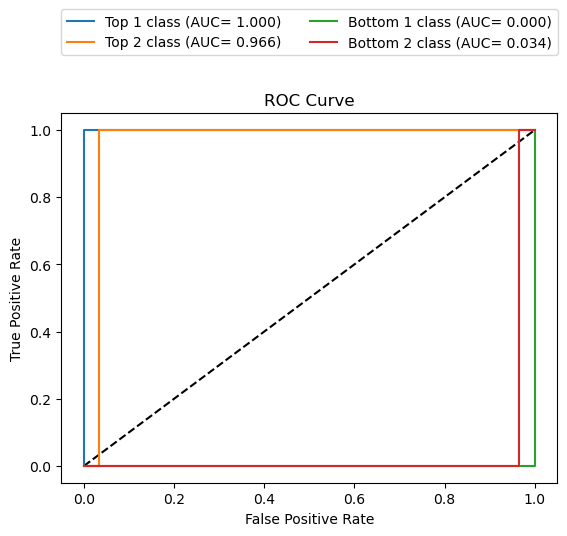

In [ ]:
# training set
ROC_curve(train_cf)

Confusion matrix for the validation set
[[0.31 0.   0.01 0.09 0.01 0.01 0.04 0.03 0.09 0.01 0.   0.   0.03 0.
  0.   0.01 0.   0.02 0.09 0.   0.07 0.01 0.02 0.1  0.   0.   0.   0.02
  0.   0.01]
 [0.   0.35 0.03 0.01 0.   0.06 0.   0.   0.   0.06 0.03 0.   0.04 0.01
  0.   0.04 0.01 0.01 0.   0.03 0.   0.   0.03 0.03 0.13 0.11 0.   0.
  0.   0.01]
 [0.   0.02 0.2  0.03 0.12 0.02 0.   0.01 0.02 0.   0.14 0.01 0.03 0.09
  0.   0.02 0.01 0.02 0.01 0.04 0.02 0.01 0.03 0.01 0.03 0.02 0.02 0.01
  0.   0.02]
 [0.08 0.   0.01 0.48 0.   0.   0.02 0.   0.1  0.   0.   0.   0.04 0.
  0.   0.   0.   0.   0.04 0.   0.04 0.   0.02 0.07 0.01 0.   0.04 0.02
  0.02 0.  ]
 [0.   0.01 0.04 0.   0.69 0.01 0.   0.   0.   0.   0.01 0.   0.   0.05
  0.   0.   0.   0.01 0.03 0.01 0.02 0.01 0.   0.   0.03 0.04 0.   0.01
  0.02 0.02]
 [0.   0.04 0.02 0.01 0.   0.44 0.04 0.03 0.   0.04 0.01 0.01 0.   0.
  0.02 0.04 0.03 0.01 0.01 0.01 0.02 0.   0.03 0.03 0.02 0.04 0.   0.
  0.01 0.03]
 [0.01 0.   0.01 0.02 0.01 0

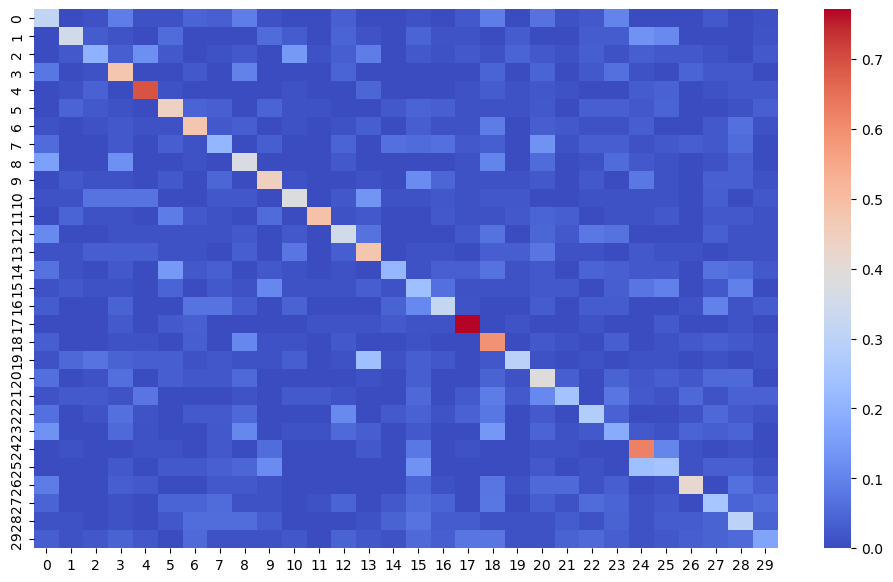

In [ ]:
# validation set
val_cf = cf_matrix(val_set, "validation")

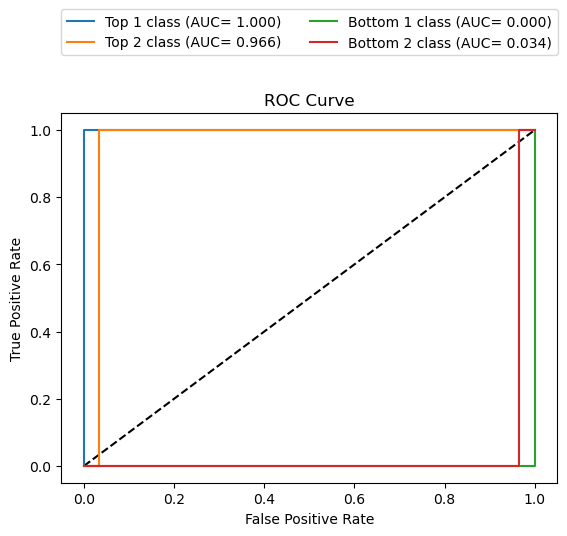

In [ ]:
# validation set
ROC_curve(val_cf)

### 2.3 Strategies for tackling overfitting

#### 2.3.1 Data augmentation


In [ ]:
# transformation for train set
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.2),
    transforms.RandomAutocontrast(p=0.1),
    transforms.RandomInvert(p=0.1)
])

In [ ]:
# transofmration for validation set
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [ ]:
train = TinyImage30(transform=train_transform)
val = TinyImage30(transform=val_transform)

In [ ]:
# Split the dataset into train(0.8) and validation(0.2) sets with seed at 0
torch.manual_seed(0)
train_set, _ = random_split(train, [10800, 2700])
torch.manual_seed(0)
_, val_set = random_split(val, [10800, 2700])

In [ ]:
# DataLoader
train_set = DataLoader(train_set, batch_size=32, shuffle=True)
val_set = DataLoader(val_set, batch_size=32)

In [ ]:
aug_model = CNN()

results = torch.load("./comp5625m-artificial-intelligence-2024/cnn_best_acc.pt")
aug_model.load_state_dict(results['state_dict'])

aug_optimizer = optim.SGD(aug_model.parameters(), lr=0.001, momentum=0.9)
aug_loss_fn = nn.CrossEntropyLoss()

print(aug_model)

CNN(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


In [ ]:
train_model(30, aug_model, aug_optimizer, aug_loss_fn, "aug") #25

Epoch 1: 
training loss:  2.633
training topk accuracy:  26.683
maximum validation accuracy:  33.039
Epoch 2: 
training loss:  2.476
training topk accuracy:  30.233
maximum validation accuracy:  34.179
Epoch 3: 
training loss:  2.433
training topk accuracy:  31.426
maximum validation accuracy:  35.172
Epoch 4: 
training loss:  2.387
training topk accuracy:  32.304
maximum validation accuracy:  35.895
Epoch 5: 
training loss:  2.341
training topk accuracy:  33.756
Epoch 6: 
training loss:  2.319
training topk accuracy:  34.393
Epoch 7: 
training loss:  2.295
training topk accuracy:  34.486
maximum validation accuracy:  37.414
Epoch 8: 
training loss:  2.266
training topk accuracy:  35.706
Epoch 9: 
training loss:  2.246
training topk accuracy:  36.280
Epoch 10: 
training loss:  2.247
training topk accuracy:  36.326
Epoch 11: 
training loss:  2.203
training topk accuracy:  36.779
maximum validation accuracy:  38.333
Epoch 12: 
training loss:  2.181
training topk accuracy:  37.851
Epoch 1

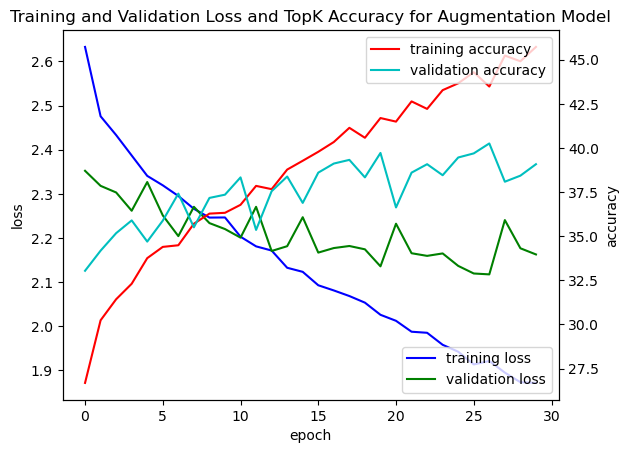

In [ ]:
plot_graph("aug", "Training and Validation Loss and TopK Accuracy for Augmentation Model")

The graph above shows that the loss and accuracy of the CNN model with augmentation applied. The validation accuracy reaches up to about 40 which is higher than the CNN without augmentation.
This indicates that applying various photometric and geometric augmentation techniques improves the model by generalising. Furthermore, it enables to predict unseen images well and increases the model accuracy, preventing over-fitting.

#### 2.3.2 Dropout

In [ ]:
class CNN_dropout(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 40, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 80, 3)

        self.fc1 = nn.Linear(80*14*14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# load the train set without augmentation
train = TinyImage30()

torch.manual_seed(0)
train_set, val_set = random_split(train, [10800, 2700])

train_set = DataLoader(train_set, batch_size=32, shuffle=True)
val_set = DataLoader(val_set, batch_size=32)

In [ ]:
dropout_model = CNN_dropout()
#dropout_model = CNN2_dropout()
results = torch.load("./comp5625m-artificial-intelligence-2024/cnn_best_acc.pt")
#results = torch.load("./comp5625m-artificial-intelligence-2024/cnn2_best_acc.pt")
dropout_model.load_state_dict(results['state_dict'])

dropout_optimizer = optim.SGD(dropout_model.parameters(), lr=0.001, momentum=0.9)
dropout_loss_fn = nn.CrossEntropyLoss()

print(dropout_model)

CNN_dropout(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
train_model(30, dropout_model, dropout_optimizer, dropout_loss_fn, "dropout")

Epoch 1: 
training loss:  1.902
training topk accuracy:  43.241
maximum validation accuracy:  30.049
Epoch 2: 
training loss:  1.816
training topk accuracy:  45.812
Epoch 3: 
training loss:  1.770
training topk accuracy:  47.023
maximum validation accuracy:  32.071
Epoch 4: 
training loss:  1.694
training topk accuracy:  48.983
maximum validation accuracy:  33.799
Epoch 5: 
training loss:  1.637
training topk accuracy:  51.174
Epoch 6: 
training loss:  1.566
training topk accuracy:  52.700
maximum validation accuracy:  34.289
Epoch 7: 
training loss:  1.516
training topk accuracy:  54.493
Epoch 8: 
training loss:  1.460
training topk accuracy:  55.889
Epoch 9: 
training loss:  1.407
training topk accuracy:  56.879
Epoch 10: 
training loss:  1.341
training topk accuracy:  59.033
Epoch 11: 
training loss:  1.295
training topk accuracy:  59.819
Epoch 12: 
training loss:  1.236
training topk accuracy:  61.899
Epoch 13: 
training loss:  1.186
training topk accuracy:  63.600
Epoch 14: 
train

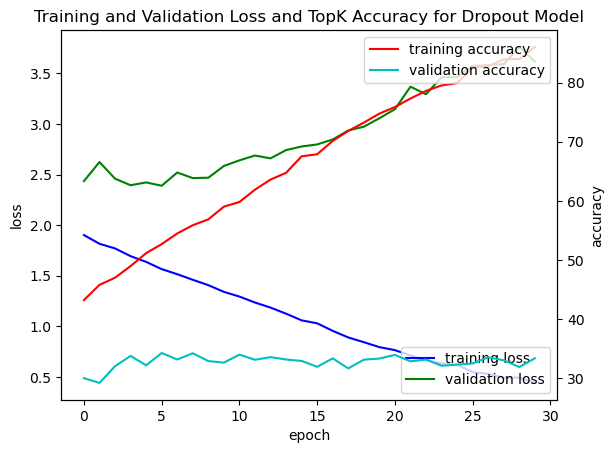

In [ ]:
plot_graph("dropout", "Training and Validation Loss and TopK Accuracy for Dropout Model")

Dropout is applied in this model, randomly dropping neurons at 0.25 probability. It helps to prevent over-fitting. The graph seems to converge faster, but with a slightly loweraccuracy

#### 2.3.3 Hyperparameter tuning

In [ ]:
hyp_model = CNN()
#hyp_model = CNN2()

results = torch.load("./comp5625m-artificial-intelligence-2024/cnn_best_acc.pt")
#results = torch.load("./comp5625m-artificial-intelligence-2024/cnn2_best_acc.pt")
hyp_model.load_state_dict(results['state_dict'])

# lr = 0.1
hyp_optimizer = optim.SGD(hyp_model.parameters(), lr=0.1, momentum=0.9)
hyp_loss_fn = nn.CrossEntropyLoss()

print(hyp_model)

CNN(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


In [ ]:
train_model(50, hyp_model, hyp_optimizer, hyp_loss_fn, "hyp_1")

Epoch 1: 
training loss:  3.474
training topk accuracy:  3.486
maximum validation accuracy:  3.824
Epoch 2: 
training loss:  3.410
training topk accuracy:  2.866
Epoch 3: 
training loss:  3.410
training topk accuracy:  3.143
Epoch 4: 
training loss:  3.410
training topk accuracy:  3.264
Epoch 5: 
training loss:  3.408
training topk accuracy:  3.541
Epoch 6: 
training loss:  3.410
training topk accuracy:  3.005
Epoch 7: 
training loss:  3.410
training topk accuracy:  3.328
Epoch 8: 
training loss:  3.410
training topk accuracy:  3.393
Epoch 9: 
training loss:  3.411
training topk accuracy:  3.245
Epoch 10: 
training loss:  3.408
training topk accuracy:  3.143
Epoch 11: 
training loss:  3.409
training topk accuracy:  3.153
Epoch 12: 
training loss:  3.410
training topk accuracy:  2.774
Epoch 13: 
training loss:  3.410
training topk accuracy:  2.940
Epoch 14: 
training loss:  3.409
training topk accuracy:  3.199
Epoch 15: 
training loss:  3.411
training topk accuracy:  3.097
Epoch 16: 
tr

In [ ]:
hyp_model = CNN()
#hyp_model = CNN2()

results = torch.load("./comp5625m-artificial-intelligence-2024/cnn_best_acc.pt")
#results = torch.load("./comp5625m-artificial-intelligence-2024/cnn2_best_acc.pt")
hyp_model.load_state_dict(results['state_dict'])

# lr = 0.001
hyp_optimizer = optim.SGD(hyp_model.parameters(), lr=0.001, momentum=0.9)
hyp_loss_fn = nn.CrossEntropyLoss()

print(hyp_model)

CNN(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


In [ ]:
train_model(50, hyp_model, hyp_optimizer, hyp_loss_fn, "hyp_2")

Epoch 1: 
training loss:  1.527
training topk accuracy:  54.706
maximum validation accuracy:  36.679
Epoch 2: 
training loss:  1.440
training topk accuracy:  57.128
Epoch 3: 
training loss:  1.360
training topk accuracy:  59.199
Epoch 4: 
training loss:  1.271
training topk accuracy:  61.816
maximum validation accuracy:  36.703
Epoch 5: 
training loss:  1.182
training topk accuracy:  64.922
Epoch 6: 
training loss:  1.075
training topk accuracy:  67.261
Epoch 7: 
training loss:  0.978
training topk accuracy:  70.775
Epoch 8: 
training loss:  0.882
training topk accuracy:  73.068
Epoch 9: 
training loss:  0.784
training topk accuracy:  76.378
Epoch 10: 
training loss:  0.676
training topk accuracy:  79.651
Epoch 11: 
training loss:  0.579
training topk accuracy:  82.711
Epoch 12: 
training loss:  0.478
training topk accuracy:  85.475
Epoch 13: 
training loss:  0.406
training topk accuracy:  88.101
Epoch 14: 
training loss:  0.336
training topk accuracy:  90.496
Epoch 15: 
training loss:

In [ ]:
hyp_model = CNN()
#hyp_model = CNN2()

results = torch.load("./comp5625m-artificial-intelligence-2024/cnn_best_acc.pt")
#results = torch.load("./comp5625m-artificial-intelligence-2024/cnn2_best_acc.pt")
hyp_model.load_state_dict(results['state_dict'])

# lr = 0.0001
hyp_optimizer = optim.SGD(hyp_model.parameters(), lr=0.0001, momentum=0.9)
hyp_loss_fn = nn.CrossEntropyLoss()

print(hyp_model)

CNN(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


In [ ]:
train_model(50, hyp_model, hyp_optimizer, hyp_loss_fn, "hyp_3")

Epoch 1: 
training loss:  1.367
training topk accuracy:  59.911
maximum validation accuracy:  37.978
Epoch 2: 
training loss:  1.328
training topk accuracy:  61.150
Epoch 3: 
training loss:  1.310
training topk accuracy:  62.010
maximum validation accuracy:  38.309
Epoch 4: 
training loss:  1.296
training topk accuracy:  62.250
Epoch 5: 
training loss:  1.280
training topk accuracy:  62.731
Epoch 6: 
training loss:  1.265
training topk accuracy:  63.452
Epoch 7: 
training loss:  1.252
training topk accuracy:  63.859
Epoch 8: 
training loss:  1.237
training topk accuracy:  63.859
Epoch 9: 
training loss:  1.224
training topk accuracy:  64.534
Epoch 10: 
training loss:  1.209
training topk accuracy:  65.126
Epoch 11: 
training loss:  1.196
training topk accuracy:  65.560
Epoch 12: 
training loss:  1.182
training topk accuracy:  65.810
Epoch 13: 
training loss:  1.167
training topk accuracy:  66.346
maximum validation accuracy:  38.395
Epoch 14: 
training loss:  1.152
training topk accura

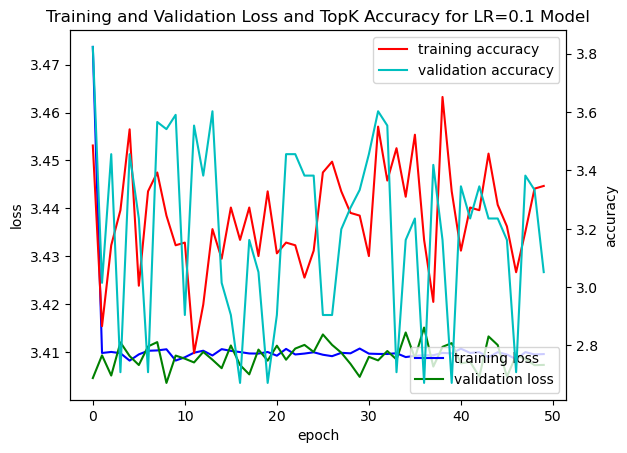

In [ ]:
plot_graph("hyp_1", "Training and Validation Loss and TopK Accuracy for LR=0.1 Model")

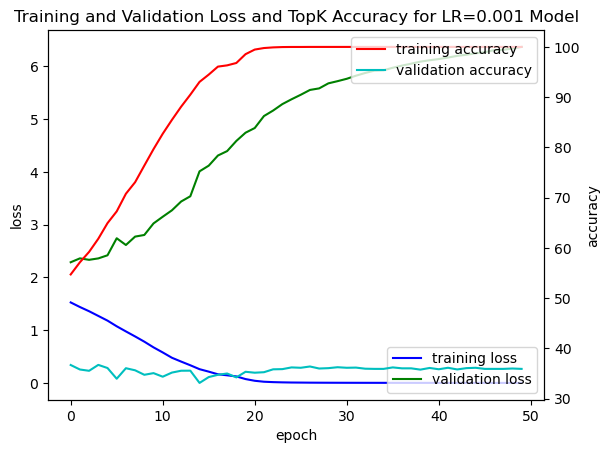

In [ ]:
plot_graph("hyp_2", "Training and Validation Loss and TopK Accuracy for LR=0.001 Model")

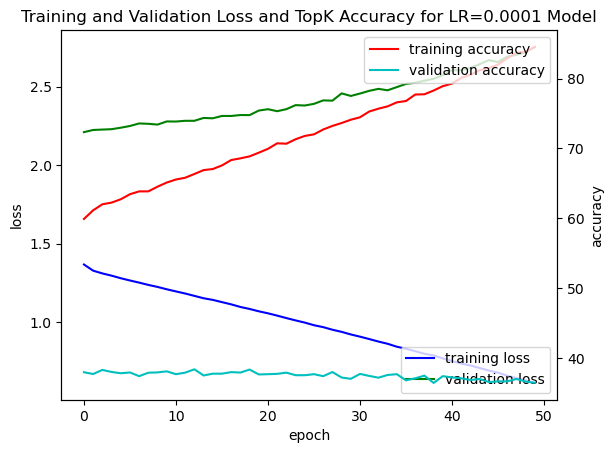

In [ ]:
plot_graph("hyp_3", "Training and Validation Loss and TopK Accuracy for LR=0.0001 Model")

Comparing three graphs with different learning rate, one can see that the accuracy varies depending on the learning rate.

The model with learning rate at 0.1 diverges too fast that the model ends up with low and unstable accuracy. The models with learning rate at 0.001 and 0.0001 works much better with similar validation accuracy. However, the validation loss for both models increases, indicating that the model might be over-fitting as the model is trained further. Furthermore, the graph indicates that the model with learning rate at 0.0001 reaches to the highest accuracy faster.

### 3 Model testing


#### 3.1 Test class and predictions

In [ ]:
# Dataset class to load test set
class TinyImage30_test(Dataset):
    def __init__(self, main_dir="./comp5625m-artificial-intelligence-2024/test_set/"):
        self.main_dir = main_dir
        self.transform = transforms.ToTensor()

        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, self.total_imgs[idx]

In [ ]:
test = TinyImage30_test()
test_set = DataLoader(test)

#### 3.2 Prepare your submission and upload to Kaggle


In [ ]:
# load the model with the best accuracy
final_model = CNN()
results = torch.load("./comp5625m-artificial-intelligence-2024/aug_best_acc.pt")
final_model.load_state_dict(results['state_dict'])

<All keys matched successfully>

In [ ]:
# save as csv file
def submission(model):
    n = len(test_set)
    labels = [None]*n
    predictions = [None]*n

    i=0
    with torch.no_grad():
        for data, label in test_set:
            labels[i] = label[0]
            outputs = model(data)
            predictions[i] = torch.argmax(outputs)
            i +=1

    f = open("mm23sl.csv", "w")
    f.write("Id,Category\n")
    for i in range(n):
        if i != n-1:
            f.write("{},{}\n".format(labels[i], predictions[i]))
        else:
            f.write("{},{}".format(labels[i], predictions[i]))
    f.close()

In [ ]:
submission(final_model)

In [ ]:
sub = pd.read_csv("final.csv")
sub

,Id,Category
0,0a32f209_1b6e.JPEG,2
1,0a130fb8_b027.JPEG,17
2,0a547c95_69b1.JPEG,2
3,0ad55c32_0758.JPEG,1
4,0ae03fbb_5363.JPEG,29
...,...,...
1495,ff3c0445_3966.JPEG,24
1496,ff5b3540_6090.JPEG,1
1497,ff0008ab_daa6.JPEG,15
1498,ff151b7e_d09f.JPEG,0


The CNN model with augmentation applied achieved the highest accuracy in Kaggle (0.402).


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset

In [ ]:
# transformation for train set
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(250),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.2),
    transforms.RandomAutocontrast(p=0.1),
    transforms.RandomInvert(p=0.1)
])

In [ ]:
# transformations for val set
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224)
])

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

train = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
val = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(len(train)*0.8)
print(len(train)*0.2)

40000.0
10000.0


In [ ]:
# Split the dataset into train(0.8) and validation(0.2) sets with seed at 0
torch.manual_seed(0)
train_set, _ = random_split(train, [40000, 10000])
torch.manual_seed(0)
_, val_set = random_split(val, [40000, 10000])

In [ ]:
# DataLoader
train_set = DataLoader(train_set, batch_size=32, shuffle=True)
val_set = DataLoader(val_set, batch_size=32)

In [ ]:
# pre-trained AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
AlexNet_model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# change the 'out_features' to 10 as the number of classes for this dataset is 10
AlexNet_model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

In [ ]:
AlexNet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### 4.1 Apply transfer learning with pretrained model weights


> Configuration 1: No frozen layers

In [ ]:
summary(AlexNet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

__Total number of Trainable Parameters for AlexNet__ : 57,044,810

In [ ]:
alex_optimizer = torch.optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)
alex_loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_model(25, AlexNet_model, alex_optimizer, alex_loss_fn, "alex")

Epoch 1: 
training loss:  1.255
training topk accuracy:  55.530
maximum validation accuracy:  70.088
Epoch 2: 
training loss:  0.879
training topk accuracy:  69.353
maximum validation accuracy:  74.111
Epoch 3: 
training loss:  0.766
training topk accuracy:  73.252
maximum validation accuracy:  78.375
Epoch 4: 
training loss:  0.683
training topk accuracy:  75.942
maximum validation accuracy:  79.702
Epoch 5: 
training loss:  0.632
training topk accuracy:  78.252
maximum validation accuracy:  80.761
Epoch 6: 
training loss:  0.602
training topk accuracy:  79.243
Epoch 7: 
training loss:  0.560
training topk accuracy:  80.690
maximum validation accuracy:  81.999
Epoch 8: 
training loss:  0.537
training topk accuracy:  81.100
Epoch 9: 
training loss:  0.508
training topk accuracy:  82.483
maximum validation accuracy:  83.197
Epoch 10: 
training loss:  0.486
training topk accuracy:  83.123
Epoch 11: 
training loss:  0.471
training topk accuracy:  83.397
maximum validation accuracy:  83.44

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [ ]:
# save the model with out_features=10
AlexNet_model2 = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
AlexNet_model2.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 124MB/s]


In [ ]:
# Frozen base convolution blocks
for name, param in AlexNet_model2.named_parameters():
    if param.requires_grad and 'features' in name:
        param.requires_grad = False
non_frozen_params = [p for p in AlexNet_model2.parameters() if p.requires_grad]

In [ ]:
AlexNet_model2.cuda()
summary(AlexNet_model2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

__Total number of Trainable Parameters for AlexNet with Frozen Layers__ : 54,575,114

In [ ]:
alex_optimizer2 = torch.optim.SGD(non_frozen_params, lr=0.001, momentum=0.9)
alex_loss_fn2 = nn.CrossEntropyLoss()

In [ ]:
train_model(25, AlexNet_model2, alex_optimizer2, alex_loss_fn2, "alex2")

Epoch 1: 
training loss:  1.512
training topk accuracy:  45.792
maximum validation accuracy:  56.480
Epoch 2: 
training loss:  1.311
training topk accuracy:  53.440
maximum validation accuracy:  57.438
Epoch 3: 
training loss:  1.247
training topk accuracy:  56.053
maximum validation accuracy:  61.252
Epoch 4: 
training loss:  1.202
training topk accuracy:  57.708
Epoch 5: 
training loss:  1.176
training topk accuracy:  58.538
maximum validation accuracy:  62.690
Epoch 6: 
training loss:  1.153
training topk accuracy:  59.633
Epoch 7: 
training loss:  1.130
training topk accuracy:  59.990
maximum validation accuracy:  62.879
Epoch 8: 
training loss:  1.119
training topk accuracy:  60.748
maximum validation accuracy:  63.349
Epoch 9: 
training loss:  1.099
training topk accuracy:  61.285
maximum validation accuracy:  63.978
Epoch 10: 
training loss:  1.088
training topk accuracy:  61.712
maximum validation accuracy:  64.976
Epoch 11: 
training loss:  1.078
training topk accuracy:  62.18

#### 4.3 Compare above configurations and comment on performances. (4 marks)

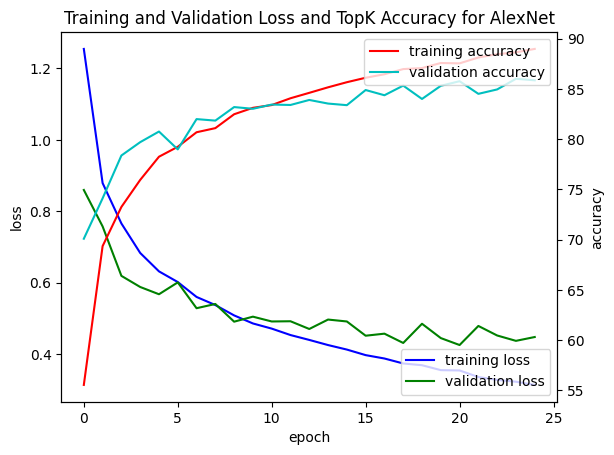

In [ ]:
# No frozen layers
plot_graph("alex", "Training and Validation Loss and TopK Accuracy for AlexNet")

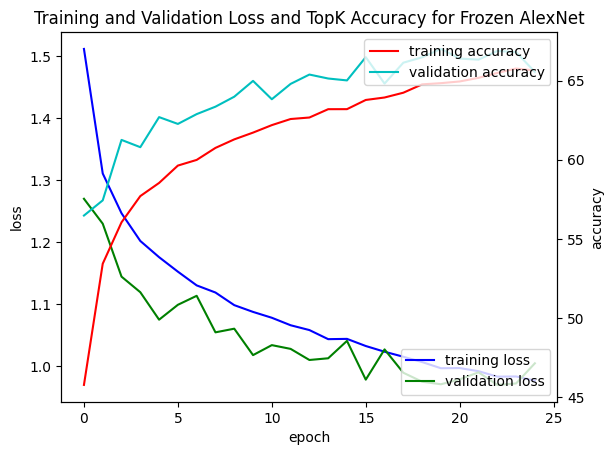

In [ ]:
# Frozen base convolution blocks
plot_graph("alex2", "Training and Validation Loss and TopK Accuracy for Frozen AlexNet")

Comparing two graphs above, the model with no frozen layers worked better, resulting higher accuracy.